# Healthy vs. IPF G2G Analysis (AT2 --> AT1 healthy trajectory vs. AT2 --> Aberrant Basaloid trajectory)

# Supplementary tests

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import VisualUtils
import PathwayAnalyserV2
import warnings
warnings.filterwarnings("ignore")
# Plotting 
import matplotlib
import warnings
import platform
import pickle
# Inline plotting
%matplotlib inline
sb.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")
print(platform.python_version())

dir_path = '../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'

adata_healthy = anndata.read_h5ad(dir_path + 'adata_healthy_AT2_to_AT1_monocle_slingshot.h5ad')
adata_disease = anndata.read_h5ad(dir_path + 'adata_IPF_AT2_to_AberrantB_monocle_slingshot.h5ad')

#with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_healthy_IPF.pkl', 'rb') as f:
#    aligner = pickle.load(f)

ModuleNotFoundError: No module named 'OrgAlign'

# Aligning PC components

In [3]:
adata_healthy

AnnData object with n_obs × n_vars = 3157 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'Celltype_HLCA', 'ANNOTATION', 'dpt_pseudotime', 'leiden_normal', 'leiden_diffmap', 'palantir_pseudotime', 'palantir_start_score', 'dpt_start_score', 'palantir_end_score', 'monocle_pseudotime', 'slingshot_pseudotime'
    var: 'Ensembl_GeneID', 'HVG'
    uns: 'Manuscript_Identity_colors', 'leiden_diffmap_colors', 'leiden_normal_colors'
    obsm: 'X_diffmap', 'X_umap'

In [4]:
adata_disease

AnnData object with n_obs × n_vars = 890 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'Celltype_HLCA', 'ANNOTATION', 'dpt_pseudotime', 'leiden_normal', 'leiden_diffmap', 'palantir_pseudotime', 'palantir_start_score', 'dpt_start_score', 'palantir_end_score', 'monocle_pseudotime', 'slingshot_pseudotime'
    var: 'Ensembl_GeneID', 'HVG'
    uns: 'Manuscript_Identity_colors', 'leiden_diffmap_colors', 'leiden_normal_colors'
    obsm: 'X_diffmap', 'X_umap'

In [5]:
adata_healthy.X.data

array([1., 1., 4., ..., 1., 1., 1.], dtype=float32)

In [6]:
adata_disease.X.data

array([1., 2., 1., ..., 1., 1., 1.], dtype=float32)

In [7]:
common_hvg_genes = np.intersect1d(adata_healthy.var_names[adata_healthy.var.HVG] , adata_disease.var_names[adata_disease.var.HVG] )
len(common_hvg_genes)

994

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


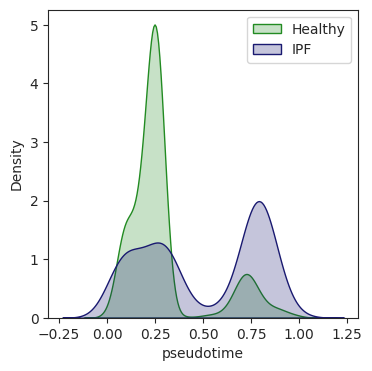

In [32]:
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['dpt_pseudotime']
adata_query.obs['time']  = adata_query.obs['dpt_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


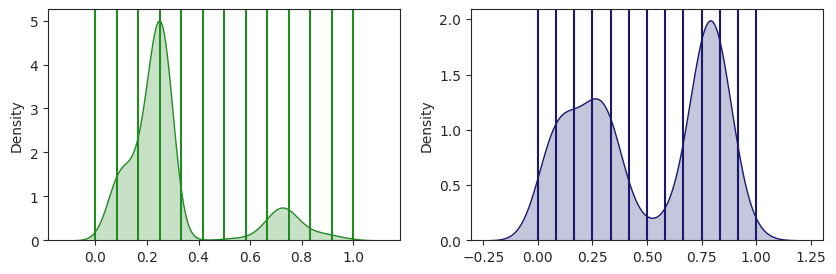

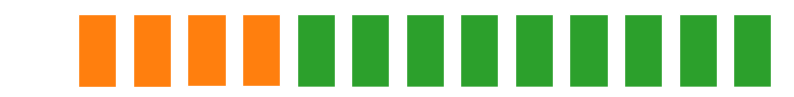

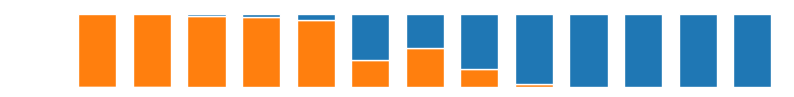

In [33]:
joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

In [34]:
print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]


In [35]:
adata_ref_original  = adata_ref.copy()
adata_query_original = adata_query.copy() 

In [36]:
sc.tl.pca(adata_ref, svd_solver='arpack')
sc.tl.pca(adata_query, svd_solver='arpack')

In [37]:
ref_pca = pd.DataFrame(adata_ref.obsm['X_pca']) 
query_pca = pd.DataFrame(adata_query.obsm['X_pca']) 

adata_ref = anndata.AnnData(X=ref_pca)
adata_query = anndata.AnnData(X=query_pca)
adata_ref.obs_names = adata_ref_original.obs_names
adata_query.obs_names = adata_query_original.obs_names
adata_ref.obs['time'] = adata_ref_original.obs['time']
adata_query.obs['time'] = adata_query_original.obs['time']

In [38]:
adata_ref.obs['Manuscript_Identity'] = adata_ref_original.obs['Manuscript_Identity']
adata_query.obs['Manuscript_Identity'] = adata_query_original.obs['Manuscript_Identity']

In [39]:
adata_ref.X.shape
adata_query.X.shape

(890, 50)

In [40]:
len(vs.optimal_bining_S)

13

In [41]:
    # start_time = time.time()
    #gene_list = human_TFs[0:100]
    aligner = Main.RefQueryAligner(adata_ref, adata_query, adata_query.var_names, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    # end_time = time.time() 

WINDOW_SIZE= 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Average Alignment:  MMMMMMIIIIDDMMMDD


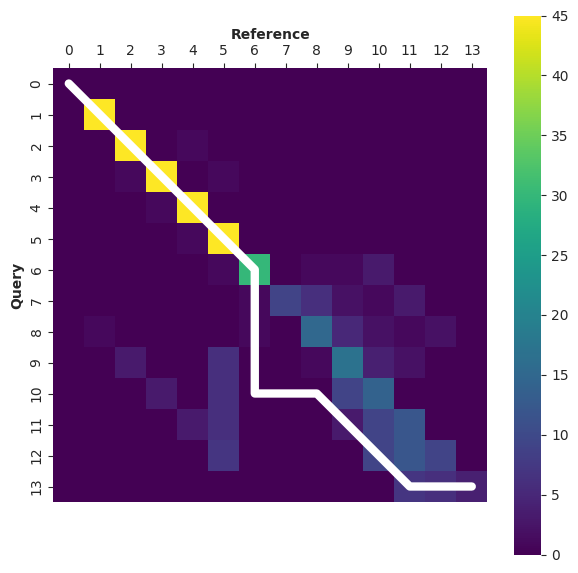

In [43]:
aligner.get_aggregate_alignment() 

In [37]:
dist1 = []
for g in aligner.gene_list:
    #print(g, aligner.results_map[g].fwd_DP.opt_cost)
    dist1.append(aligner.results_map[g].fwd_DP.opt_cost)

In [38]:
    # start_time = time.time()
    #gene_list = human_TFs[0:100]
    aligner = Main.RefQueryAligner(adata_query, adata_ref, adata_query.var_names, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 
    # end_time = time.time() 

WINDOW_SIZE= 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

In [40]:
dist2 = []
for g in aligner.gene_list:
    #print(g, aligner.results_map[g].fwd_DP.opt_cost)
    dist2.append(aligner.results_map[g].fwd_DP.opt_cost)

In [42]:
np.asarray(dist1) 

array([58.11853356, 56.60936004, 45.94619979, 46.47909041, 53.47155304,
       54.62395939, 44.92270938, 38.6894005 , 39.09352219, 48.29620799,
       36.30041406, 34.10019272, 37.32554734, 35.45854366, 46.6244865 ,
       38.957921  , 39.65702883, 33.20122652, 31.03135688, 36.69861236,
       27.71870042, 19.05327274, 29.18580423, 29.50017992, 32.27299021,
       27.79113935, 33.89536546, 31.30852918, 25.67605146, 29.54776118,
       32.1879361 , 23.45776689, 31.60392596, 28.533393  , 20.75314749,
       33.06998009, 28.7500292 , 30.23311623, 31.89657229, 29.11472502,
       29.79827381, 25.05140725, 18.34702997, 12.73520267, 26.24232058,
       24.49296137, 30.5655214 , 28.63861415, 22.48927392, 23.66216493])

In [43]:
np.asarray(dist2) 

array([58.11853356, 56.60936004, 45.94619979, 46.47909041, 53.47155304,
       54.62395939, 44.92270938, 38.6894005 , 39.09352219, 48.29620799,
       36.30041406, 34.10019272, 37.32554734, 35.45854366, 46.6244865 ,
       38.957921  , 39.65702883, 33.20122652, 31.03135688, 36.69861236,
       27.71870042, 19.05327274, 29.18580423, 29.50017992, 32.27299021,
       27.79113935, 33.89536546, 31.30852918, 25.67605146, 29.54776118,
       32.1879361 , 23.45776689, 31.60392596, 28.533393  , 20.75314749,
       33.06998009, 28.7500292 , 30.23311623, 31.89657229, 29.11472502,
       29.79827381, 25.05140725, 18.34702997, 12.73520267, 26.24232058,
       24.49296137, 30.5655214 , 28.63861415, 22.48927392, 23.66216493])

# G2G Alignment across different pseudotime estimations (monocle, slingshot, dpt)

0.0 1171.8890586476668
0.0 146.57302036246045
0.0 1.0
0.0 1.0


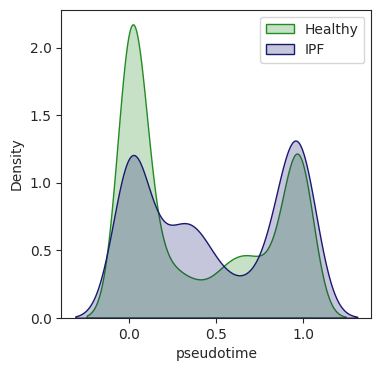

In [9]:
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['slingshot_pseudotime']
adata_query.obs['time']  = adata_query.obs['slingshot_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


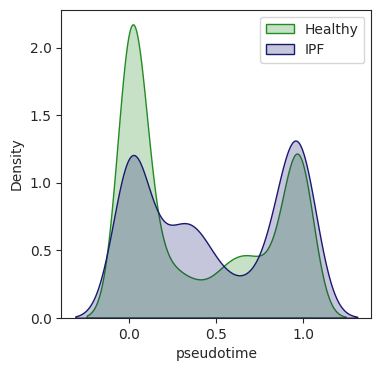

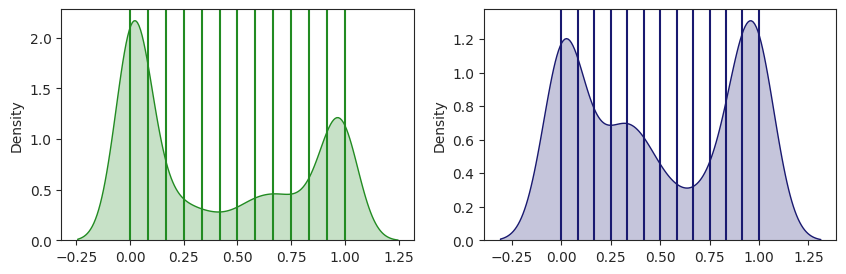

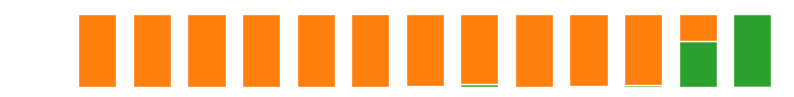

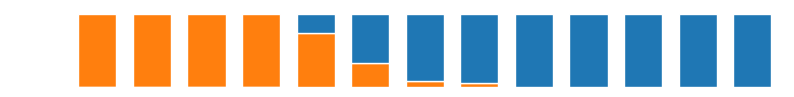

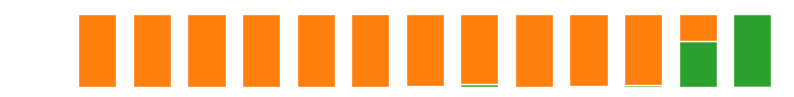

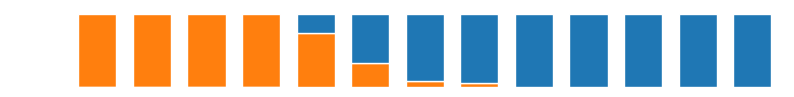

In [12]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/slingshot_dists.png')


joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/slingshot_healthy_timebins.pdf')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/slingshot_ipf_timebins.pdf')



# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


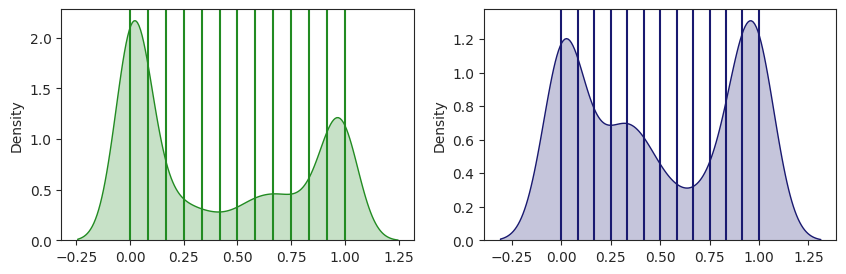

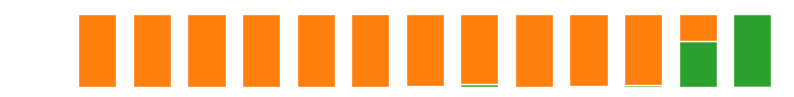

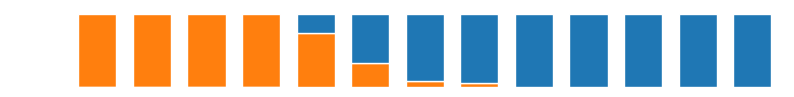

In [9]:
joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

In [10]:

print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

# RUN G2G ALIGNMENT
RUN_G2G = True
if(RUN_G2G):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMM


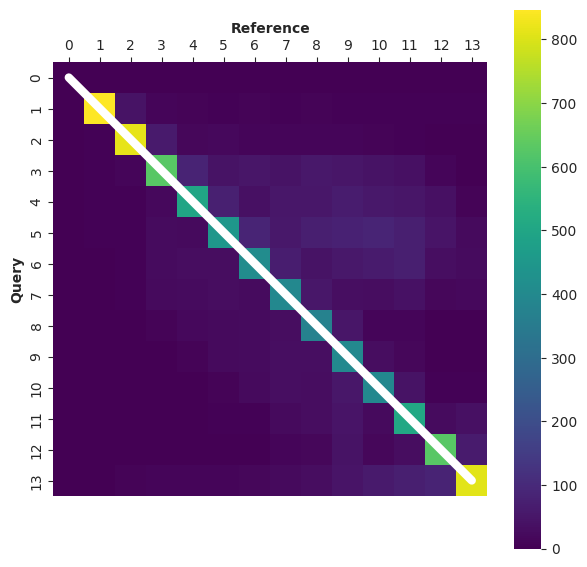

In [11]:
aligner.get_aggregate_alignment()

mean matched percentage: 
67.72 %


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,9/200,0.000013,0.000438,0,0,6.967799,78.251501,IL32;CXCL8;COL6A2;NTM;ITGA2;ADAM12;TNC;FN1;TIMP3,3.358807,3.358807
33,KEGG_2021_Human,Cytokine-cytokine receptor interaction,10/295,0.000050,0.004804,0,0,5.202818,51.513713,IL32;CSF3;CXCL8;IL1R1;GDF15;CCL20;TNFRSF10C;IL...,2.318357,2.318357
34,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,6/100,0.000079,0.004804,0,0,9.275970,87.573101,CXCL8;CCL20;IL20RA;TNFRSF10C;CXCL3;TNFRSF10D,2.318357,2.318357
1,MSigDB_Hallmark_2020,KRAS Signaling Up,7/200,0.000574,0.009468,0,0,5.283247,39.430093,AKAP12;PIGR;SLPI;CCL20;ITGA2;ANGPTL4;HDAC9,2.023756,2.023756
35,KEGG_2021_Human,ECM-receptor interaction,5/88,0.000410,0.016555,0,0,8.695365,67.808401,ITGA2;COL6A2;TNC;FN1;ITGB8,1.781061,1.781061
2,MSigDB_Hallmark_2020,Hypoxia,6/200,0.003083,0.025433,0,0,4.471801,25.855534,CA12;AKAP12;DTNA;ANGPTL4;CP;MT1E,1.594596,1.594596
3,MSigDB_Hallmark_2020,Inflammatory Response,6/200,0.003083,0.025433,0,0,4.471801,25.855534,CSF3;CXCL8;IL1R1;CCL20;ITGB8;SLC7A2,1.594596,1.594596


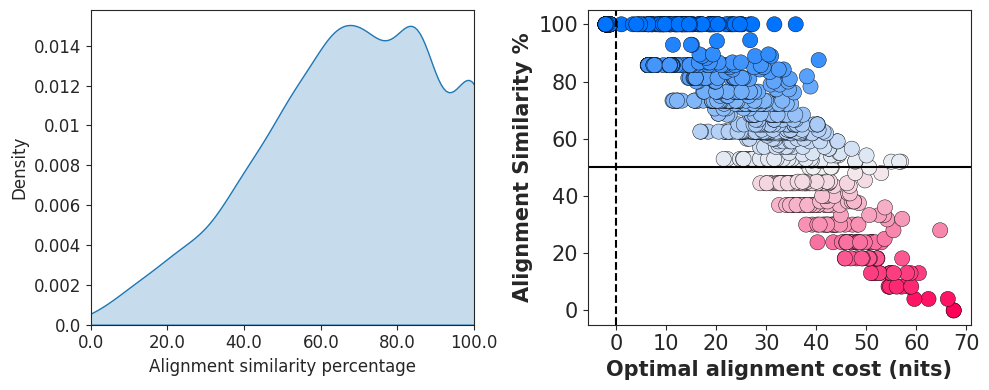

In [12]:
df = aligner.get_stat_df()
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

In [16]:
aligner_slingshot = aligner

In [17]:
#aligner.show_ordered_alignments() 

In [18]:
# monocle 

In [13]:
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['monocle_pseudotime']
adata_query.obs['time']  = adata_query.obs['monocle_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) )

0.0 21.12202188952717
0.0 9.804504992961103
0.0 1.0
0.0 1.0


# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


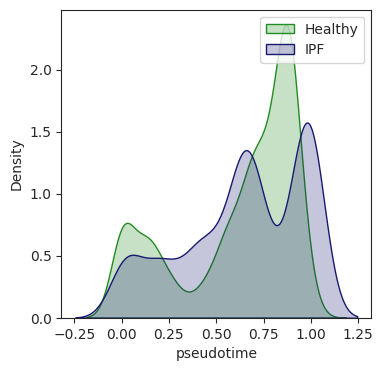

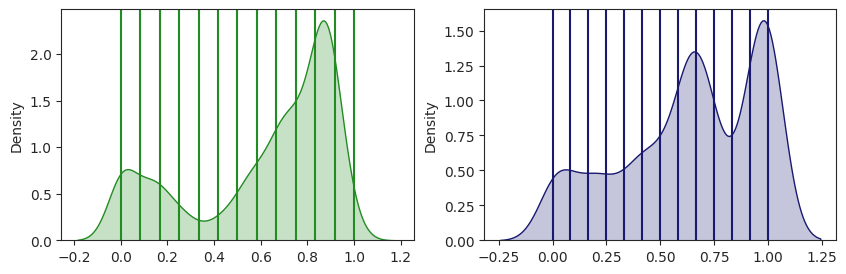

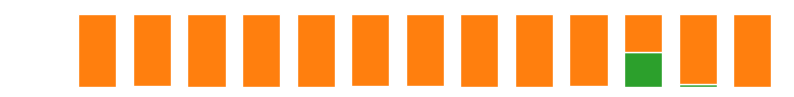

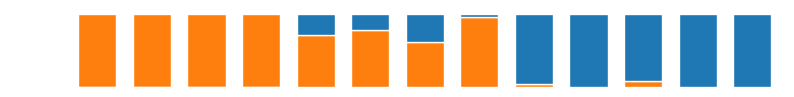

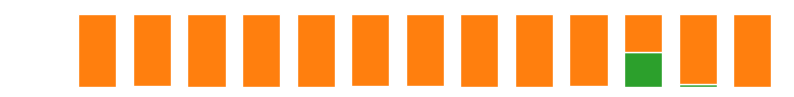

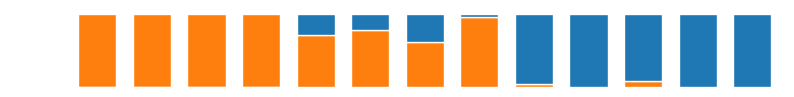

In [14]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/monocle_dists.png')


joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/monocle_healthy_timebins.pdf')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/monocle_ipf_timebins.pdf')



0.0 21.12202188952717
0.0 9.804504992961103
0.0 1.0
0.0 1.0


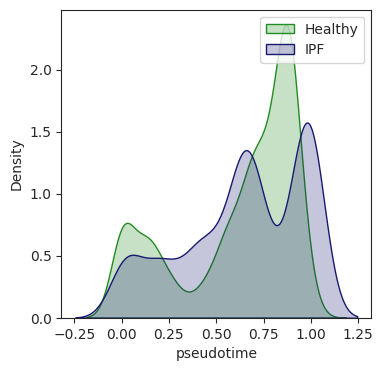

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

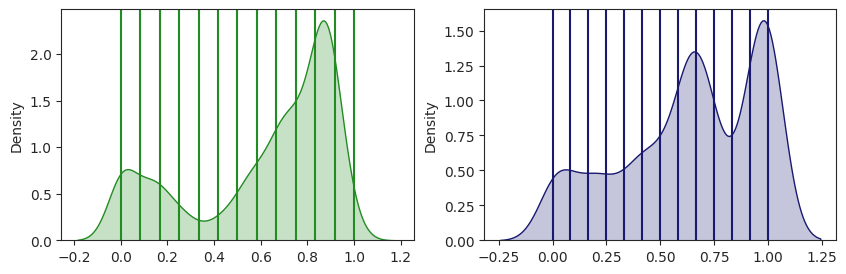

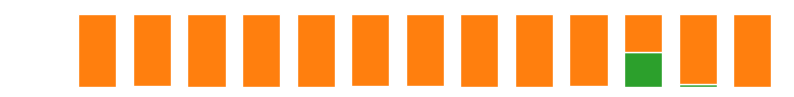

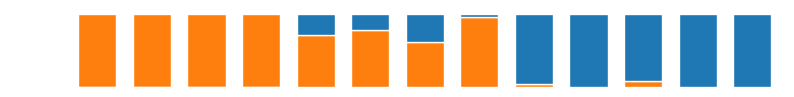

In [19]:
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['monocle_pseudotime']
adata_query.obs['time']  = adata_query.obs['monocle_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)
print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

# RUN G2G ALIGNMENT
RUN_G2G = True
if(RUN_G2G):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()

Average Alignment:  MMMMMMMMMMMMM


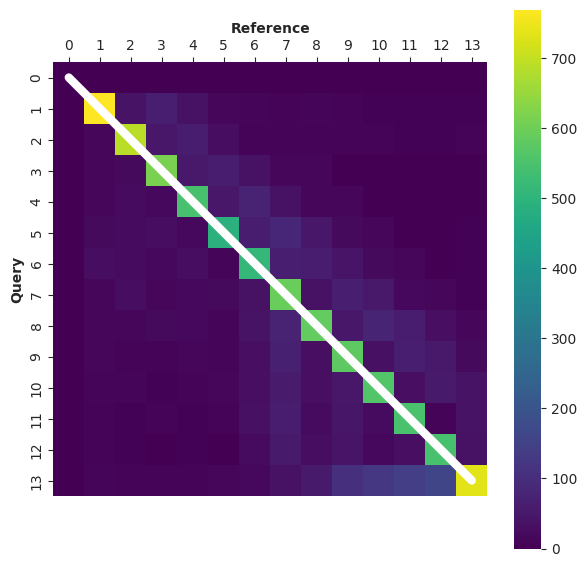

In [20]:
aligner.get_aggregate_alignment()

In [23]:
#aligner.show_ordered_alignments() 

mean matched percentage: 
77.14 %


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,13/200,0.000007,0.000277,0,0,4.954097,58.984190,IL32;NTM;ITGA2;SERPINE1;FN1;LAMC2;BMP1;COL4A2;...,3.557989,3.557989
1,MSigDB_Hallmark_2020,Inflammatory Response,10/200,0.000651,0.008877,0,0,3.709481,27.219084,MSR1;CSF3;HRH1;CCL20;MEP1A;SERPINE1;NAMPT;ITGB...,2.051739,2.051739
2,MSigDB_Hallmark_2020,KRAS Signaling Up,10/200,0.000651,0.008877,0,0,3.709481,27.219084,AKAP12;PIGR;SLPI;CCL20;ITGA2;ALDH1A2;IRF8;ANGP...,2.051739,2.051739
3,MSigDB_Hallmark_2020,Coagulation,8/138,0.000866,0.008877,0,0,4.319382,30.458480,BMP1;MMP7;MEP1A;ITGA2;SERPINE1;FGG;FN1;TIMP3,2.051739,2.051739
4,MSigDB_Hallmark_2020,Estrogen Response Late,9/200,0.002472,0.020270,0,0,3.308938,19.862746,TOP2A;PDLIM3;CAV1;BCL2;SFN;SNX10;LAMC2;FKBP5;LTF,1.693150,1.693150
5,MSigDB_Hallmark_2020,UV Response Dn,7/144,0.004823,0.032961,0,0,3.572263,19.055362,MMP16;CAV1;SERPINE1;AKT3;KCNMA1;MT1E;SYNE1,1.482005,1.482005
6,MSigDB_Hallmark_2020,Hypoxia,8/200,0.008446,0.043286,0,0,2.915323,13.917945,AKAP12;DTNA;CAV1;SERPINE1;BCL2;SLC2A1;ANGPTL4;...,1.363657,1.363657
7,MSigDB_Hallmark_2020,Estrogen Response Early,8/200,0.008446,0.043286,0,0,2.915323,13.917945,PDLIM3;BCL2;SLC2A1;KAZN;SFN;RETREG1;SLC7A2;FKBP5,1.363657,1.363657


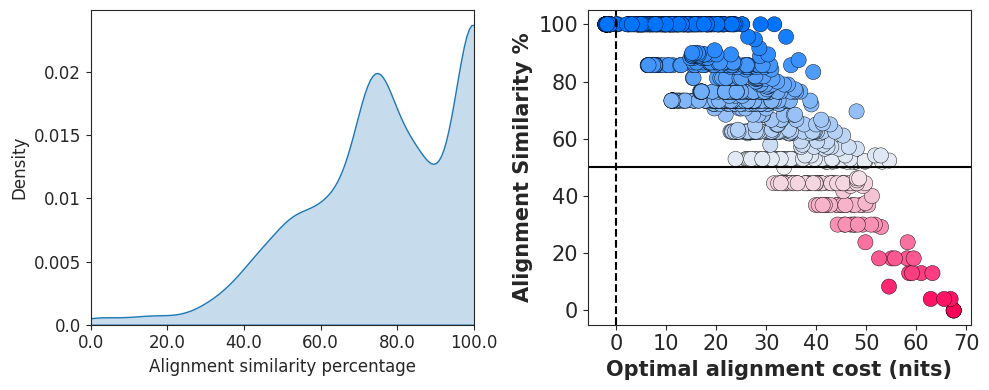

In [24]:
df = aligner.get_stat_df()
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.7)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

In [25]:
aligner_monocle = aligner

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


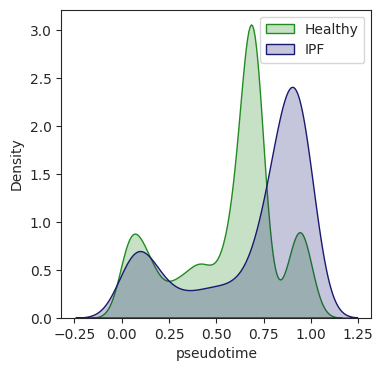

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


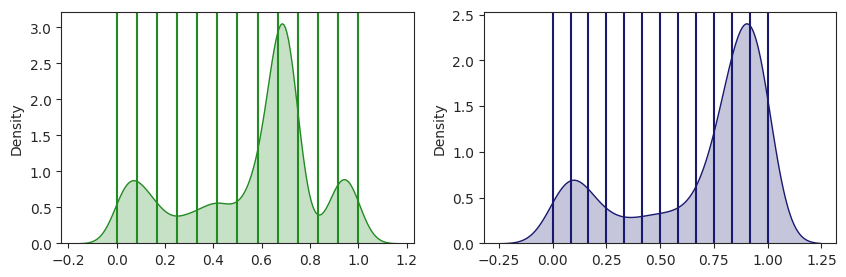

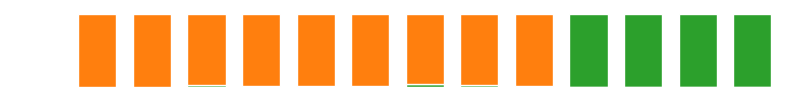

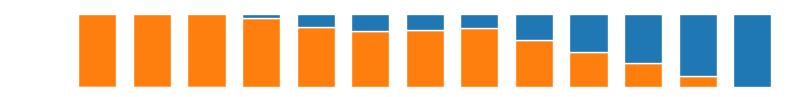

In [15]:
# palantir
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['palantir_pseudotime']
adata_query.obs['time']  = adata_query.obs['palantir_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)


# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


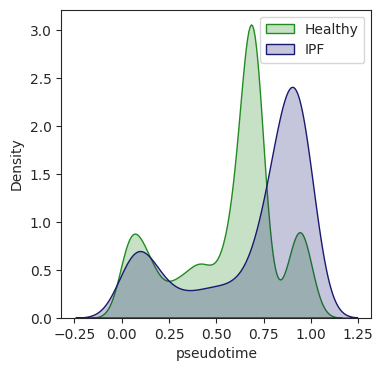

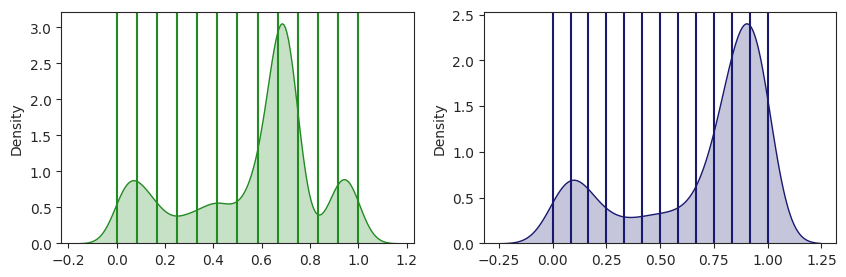

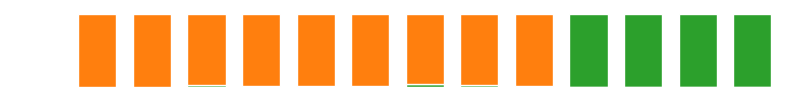

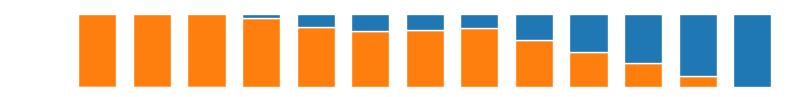

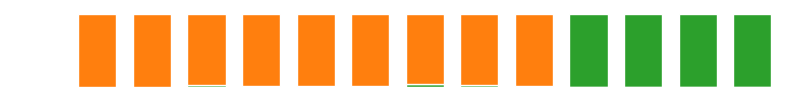

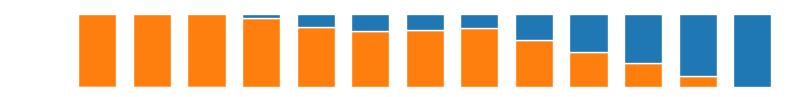

In [16]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/palantir_dists.png')


joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/palantir_healthy_timebins.pdf')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/palantir_ipf_timebins.pdf')



In [27]:
print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

# RUN G2G ALIGNMENT
RUN_G2G = True
if(RUN_G2G):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMM


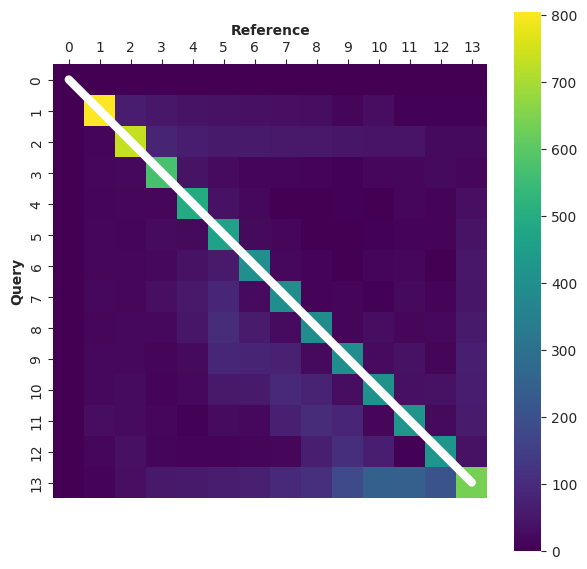

In [28]:
aligner.get_aggregate_alignment()

mean matched percentage: 
73.76 %


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,Estrogen Response Early,5/200,0.000449,0.005168,0,0,8.579313,66.125374,PDLIM3;KAZN;RETREG1;SLC7A2;FKBP5,2.286643,2.286643
1,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,5/200,0.000449,0.005168,0,0,8.579313,66.125374,CXCL8;ITGA2;NTM;FN1;TIMP3,2.286643,2.286643
2,MSigDB_Hallmark_2020,Coagulation,4/138,0.001000,0.007670,0,0,9.851741,68.048600,MMP7;ITGA2;FN1;TIMP3,2.115181,2.115181
3,MSigDB_Hallmark_2020,KRAS Signaling Up,4/200,0.003861,0.017762,0,0,6.714286,37.309637,AKAP12;CCL20;ITGA2;HDAC9,1.750510,1.750510
4,MSigDB_Hallmark_2020,Inflammatory Response,4/200,0.003861,0.017762,0,0,6.714286,37.309637,CXCL8;CCL20;ITGB8;SLC7A2,1.750510,1.750510
23,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,4/100,0.000297,0.037421,0,0,13.777778,111.900339,CXCL8;TNFSF14;CCL20;TNFRSF10C,1.426882,1.426882


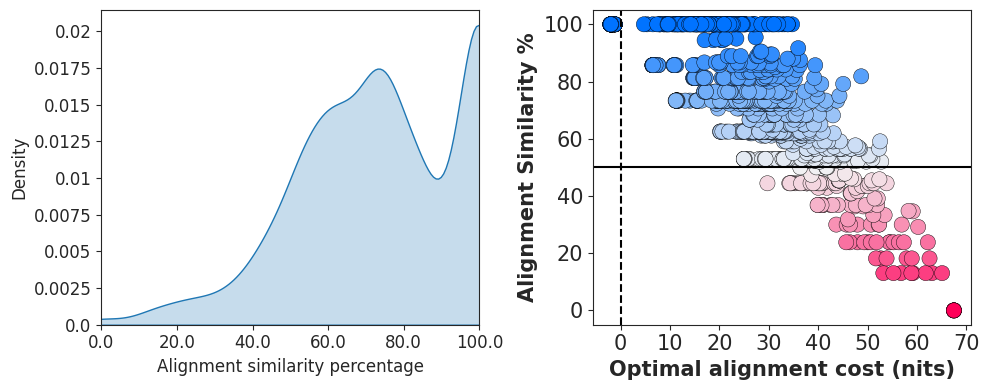

In [29]:
df = aligner.get_stat_df()
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

In [31]:
aligner_palantir = aligner

In [32]:
aligner_palantir 

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


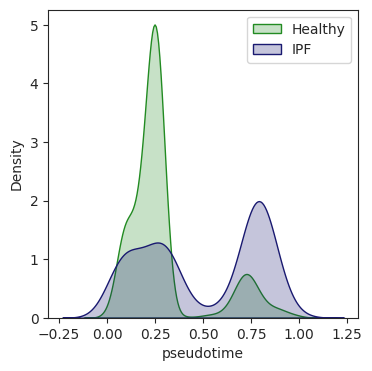

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


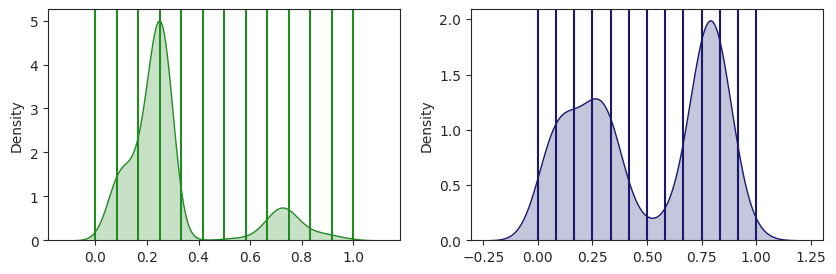

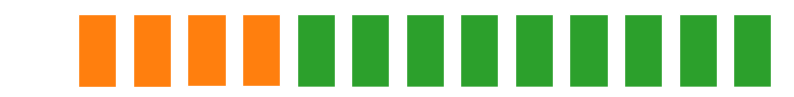

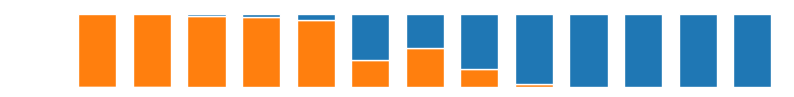

In [21]:
# palantir
adata_ref = adata_healthy.copy()
adata_query = adata_disease.copy()

adata_ref.obs['time']  = adata_ref.obs['dpt_pseudotime']
adata_query.obs['time']  = adata_query.obs['dpt_pseudotime']

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

#adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
#adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

print( np.min(adata_ref.obs.time) , np.max(adata_ref.obs.time) ) 
print( np.min(adata_query.obs.time) , np.max(adata_query.obs.time) ) 

# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)


# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


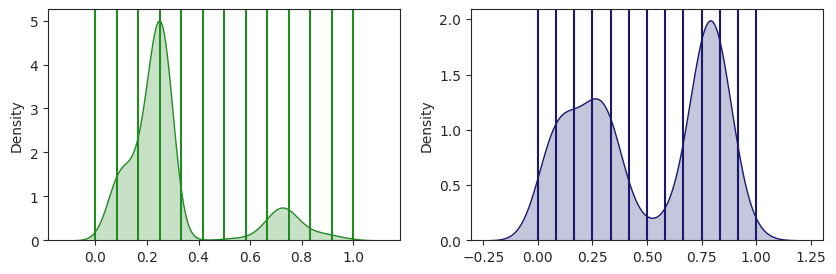

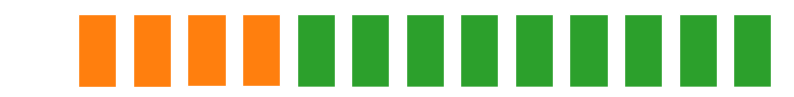

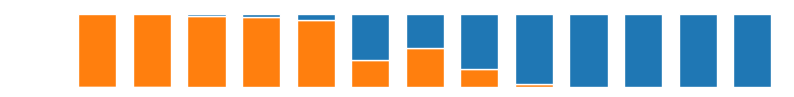

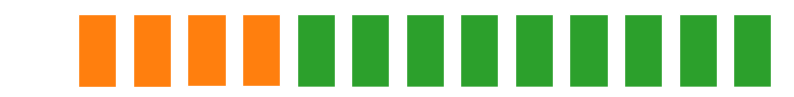

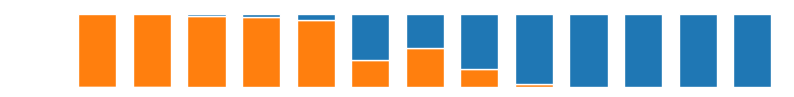

In [22]:

joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/Z1.png')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/Z2.png')


# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13


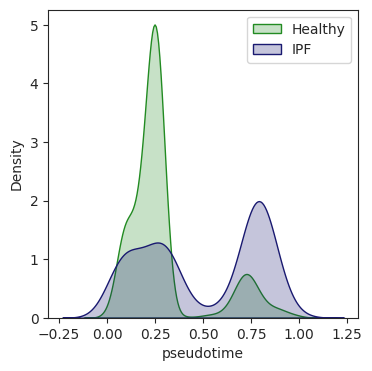

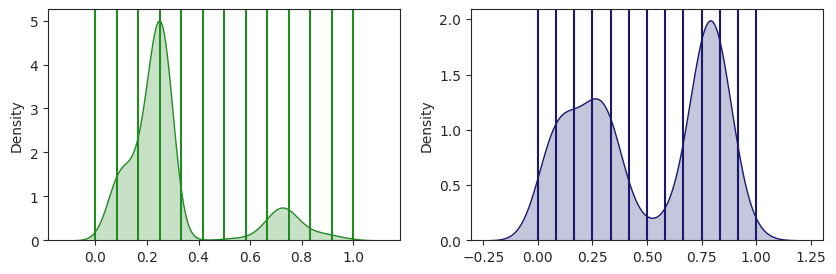

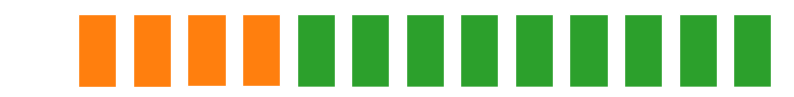

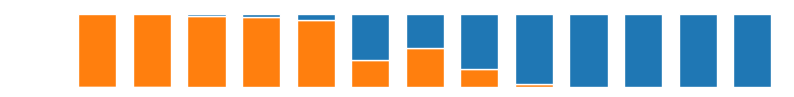

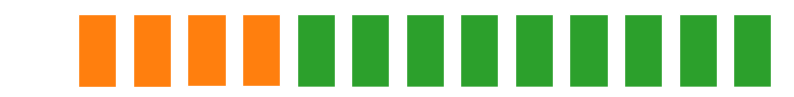

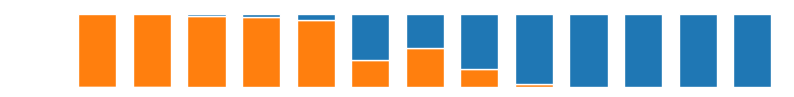

In [18]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Healthy', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/dpt_dists.png')


joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=13, ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/dpt_healthy_timebins.pdf')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('revision_figs/healthyipf_different_pseudotime_estimators/dpt_ipf_timebins.pdf')



In [ ]:
print(adata_ref.X.data) 
print(adata_query.X.data)
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)
print(adata_ref.X.data)
print(adata_query.X.data)

# RUN G2G ALIGNMENT
RUN_G2G = True
if(RUN_G2G):
    aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs()

[1. 1. 4. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[1.7595813 1.7595813 3.0076618 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMIMDID


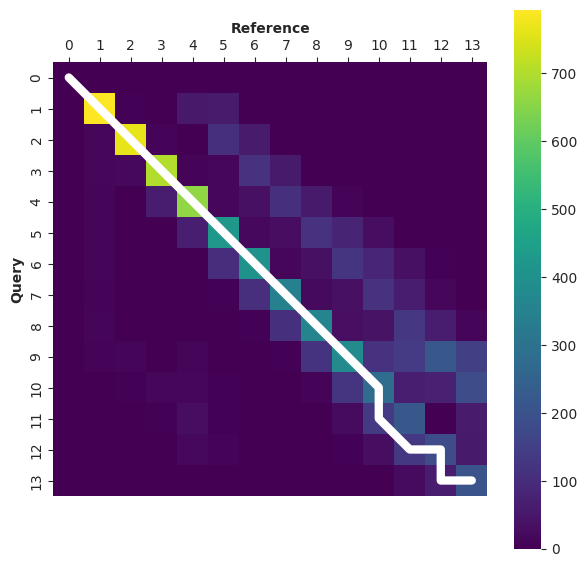

In [55]:
aligner.get_aggregate_alignment()

mean matched percentage: 
60.809999999999995 %


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,16/200,5.389872e-10,2.209848e-08,0,0,8.564999,182.788461,NNMT;CXCL8;NTM;ITGA2;LAMA3;FN1;TNC;PLOD2;LAMC2...,7.655638,7.655638
41,KEGG_2021_Human,AGE-RAGE signaling pathway in diabetic complic...,10/100,1.246035e-07,2.392387e-05,0,0,10.674797,169.709296,CXCL8;COL4A2;COL4A1;AKT3;FN1;PLCE1;CCL2;NFATC1...,4.621168,4.621168
42,KEGG_2021_Human,ECM-receptor interaction,8/88,4.812762e-06,4.620251e-04,0,0,9.519324,116.556878,COL4A2;COL4A1;ITGA2;LAMA3;TNC;FN1;ITGB8;LAMC2,3.335334,3.335334
43,KEGG_2021_Human,Focal adhesion,11/201,1.183309e-05,6.930857e-04,0,0,5.561017,63.087567,COL4A2;COL4A1;CAV1;ITGA2;AKT3;LAMA3;FN1;TNC;IT...,3.159213,3.159213
44,KEGG_2021_Human,Amoebiasis,8/102,1.443928e-05,6.930857e-04,0,0,8.095796,90.232164,CXCL8;COL4A2;IL1R1;COL4A1;LAMA3;FN1;LAMC2;RAB7A,3.159213,3.159213
1,MSigDB_Hallmark_2020,Inflammatory Response,10/200,6.369418e-05,1.305731e-03,0,0,5.030809,48.604743,ABCA1;HRH1;CXCL8;GCH1;IL1R1;CCL20;SLC11A2;ITGB...,2.884146,2.884146
45,KEGG_2021_Human,Small cell lung cancer,7/92,6.080511e-05,2.334916e-03,0,0,7.799774,75.718930,COL4A2;COL4A1;ITGA2;AKT3;LAMA3;FN1;LAMC2,2.631729,2.631729
2,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,9/200,3.246772e-04,4.437254e-03,0,0,4.481930,36.001902,ABCA1;TNFAIP8;GCH1;CCL20;DDX58;TNC;CCL2;SLC2A3...,2.352886,2.352886
3,MSigDB_Hallmark_2020,Androgen Response,6/100,7.408899e-04,7.594122e-03,0,0,6.013743,43.345008,TNFAIP8;HMGCS1;BMPR1B;NDRG1;PLPP1;FKBP5,2.119522,2.119522
4,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,7/199,5.845951e-03,2.735249e-02,0,0,3.434270,17.659036,SOCS2;MYO1E;P4HA1;SLC2A3;NDRG1;AGER;PLPP1,1.563003,1.563003


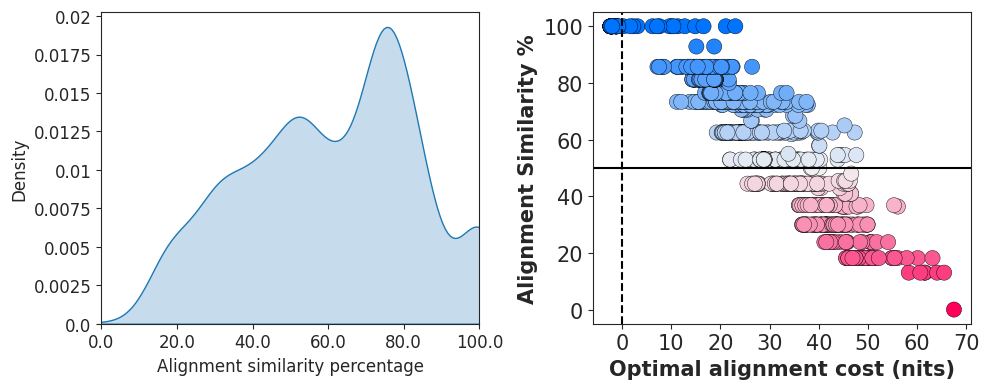

In [35]:
df = aligner.get_stat_df()
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

# Stability tests

# sampling random 50% donor subsets for G2G alignment acorss 10 iterations

In [4]:
adata_healthy_original = adata_healthy.copy() 
adata_disease_original = adata_disease.copy() 

In [5]:
ref_donors = np.unique(adata_healthy.obs.Subject_Identity, return_counts=True) 
filter_donors = np.where(ref_donors[1] <50) 
ref_donors = ref_donors[0]
fixed_ref_donors = ref_donors[filter_donors]
ref_donors = ref_donors[[d not in fixed_ref_donors for d in ref_donors] ] 
print(len(ref_donors) + len(fixed_ref_donors))

query_donors = np.unique(adata_disease.obs.Subject_Identity, return_counts=True) 
filter_donors = np.where(query_donors[1] <50) 
query_donors = query_donors[0]
fixed_query_donors = query_donors[filter_donors]
query_donors = query_donors[[d not in fixed_query_donors for d in query_donors] ] 
print(len(query_donors) + len(fixed_query_donors)) 

ref_donor_subsets = []
query_donor_subsets = []

np.random.seed(1234)
for i in range(0,5):
    subset_donors = np.random.choice(ref_donors, 6, replace=False)
    ref_donor_subsets.append(list(subset_donors)) # first from complimentary pair 
    ref_donor_subsets.append(list(np.setdiff1d(ref_donors, subset_donors))) # second from complimentary pair 
    
print('****************************')
np.random.seed(1234)
for i in range(0,5):
    subset_donors = np.random.choice(query_donors, 3, replace=False)
    query_donor_subsets.append(list(subset_donors)) # first from complimentary pair 
    query_donor_subsets.append(list(np.setdiff1d(query_donors, subset_donors))) # second from complimentary pair 

28
31
****************************


In [7]:
print(len(ref_donors) , len(fixed_ref_donors))
print(len(query_donors) , len(fixed_query_donors)) 

12 16
7 24


In [6]:
print(len(ref_donor_subsets))
print(len(query_donor_subsets)) 

10
10


In [9]:
common_hvg_genes = np.intersect1d(adata_healthy.var_names[adata_healthy.var.HVG] , adata_disease.var_names[adata_disease.var.HVG] )
len(common_hvg_genes)

994

In [11]:
adata_healthy_original.X.data

array([1., 1., 4., ..., 1., 1., 1.], dtype=float32)

9
(985, 45947)
(626, 45947)
22 / 28
28 / 31
0.0 0.8218477
0.025293315 1.0
0.0 1.0
0.0 1.0


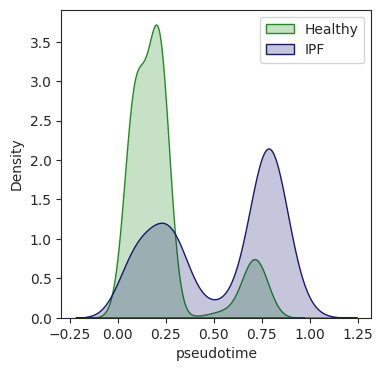

# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 4. 1. ... 1. 1. 1.]
[1. 2. 1. ... 1. 1. 1.]
[0.7517459 1.7016153 0.7517459 ... 1.2661365 1.2661365 1.2661365]
[1.1192989 1.6342111 1.1192989 ... 1.284542  1.284542  1.284542 ]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMVIDDDMDII


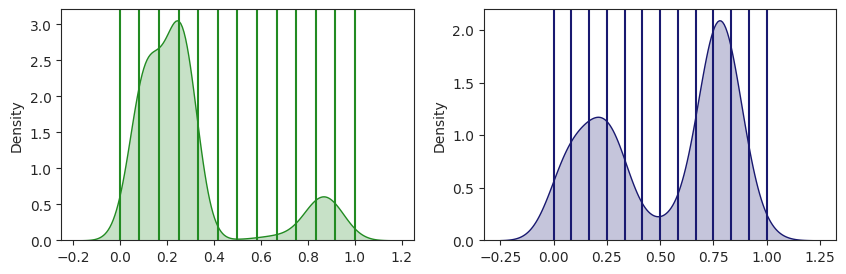

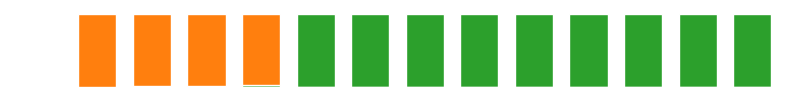

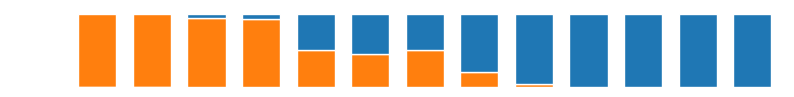

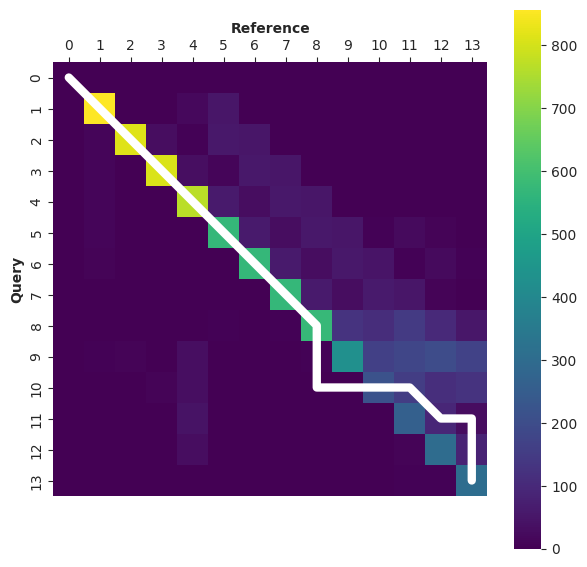

In [20]:
for i in range(9,10):
    print(i)
    adata_healthy = adata_healthy_original.copy()
    adata_disease = adata_disease_original.copy()
    
    r = ref_donor_subsets[i]
    subset = r+ list(fixed_ref_donors)
 #   print(len(subset), len(np.unique(subset)))

    adata_healthy = adata_healthy[[donor in subset for donor in adata_healthy.obs.Subject_Identity]]
    
    q = query_donor_subsets[i]
    subset = q+ list(fixed_query_donors)
#    print(len(subset), len(np.unique(subset)))
    
    adata_disease = adata_disease[[donor in subset for donor in adata_disease.obs.Subject_Identity]]
    
    print(adata_healthy.shape)
    print(adata_disease.shape)
    
    print(len(np.unique(adata_healthy.obs.Subject_Identity)), '/', len(np.unique(adata_healthy_original.obs.Subject_Identity)))
    print(len(np.unique(adata_disease.obs.Subject_Identity)), '/', len(np.unique(adata_disease_original.obs.Subject_Identity)))
    
  #  sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
  #  sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
   # print('-----')

    adata_healthy.obs['time'] = adata_healthy.obs['dpt_pseudotime']
    adata_disease.obs['time'] = adata_disease.obs['dpt_pseudotime']

    print( np.min(adata_healthy.obs.time) , np.max(adata_healthy.obs.time) ) 
    print( np.min(adata_disease.obs.time) , np.max(adata_disease.obs.time) ) 
    
    adata_healthy.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_healthy.obs['time']))
    adata_disease.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_disease.obs['time']))
    
    print( np.min(adata_healthy.obs.time) , np.max(adata_healthy.obs.time) ) 
    print( np.min(adata_disease.obs.time) , np.max(adata_disease.obs.time) ) 
    
    
    # Examine ref and query pseudotime distributions
    sb.kdeplot(adata_healthy.obs['dpt_pseudotime'], fill=True, label='Healthy', color='forestgreen') 
    sb.kdeplot(adata_disease.obs['dpt_pseudotime'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
    plt.show()
    
    joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_healthy, adata_disease, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

    
    adata_ref = adata_healthy
    adata_query = adata_disease
    print(adata_ref.X.data) 
    print(adata_query.X.data)
    sc.pp.normalize_per_cell(adata_ref, 10000) 
    sc.pp.log1p(adata_ref)
    sc.pp.normalize_per_cell(adata_query, 10000) 
    sc.pp.log1p(adata_query)
    print(adata_ref.X.data)
    print(adata_query.X.data)

    # RUN G2G ALIGNMENT
    RUN_G2G = True
    if(RUN_G2G):
        aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
        aligner.WEIGHT_BY_CELL_DENSITY = True
        aligner.WINDOW_SIZE=0.1
        aligner.state_params = [0.99,0.1,0.7]
        aligner.optimal_binning = True
        aligner.opt_binning_S = vs.optimal_bining_S
        aligner.opt_binning_T = vs.optimal_bining_T
        aligner.align_all_pairs()
    
        aligner.get_aggregate_alignment()
    
    break


In [29]:
int(adata_healthy.shape[0]  * 50/100) 

1578

In [30]:
adata_healthy[np.random.choice(adata_healthy.obs_names, int(adata_healthy.shape[0]  * 50/100) , replace=False)]

View of AnnData object with n_obs × n_vars = 1578 × 45947
    obs: 'nUMI', 'nGene', 'CellType_Category', 'Manuscript_Identity', 'Subclass_Cell_Identity', 'Disease_Identity', 'Subject_Identity', 'Library_Identity', 'Celltype_HLCA', 'ANNOTATION', 'dpt_pseudotime', 'leiden_normal', 'leiden_diffmap', 'palantir_pseudotime', 'palantir_start_score', 'dpt_start_score', 'palantir_end_score'
    var: 'Ensembl_GeneID', 'HVG'
    uns: 'Manuscript_Identity_colors', 'leiden_diffmap_colors', 'leiden_normal_colors'
    obsm: 'X_diffmap', 'X_umap'

# Additional test -- sampling 50% of cells to align from each reference and query regardless of donor composition.

0
0.0 1.0
0.024199817 1.0
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 1. 1. ... 1. 1. 1.]
[5. 4. 2. ... 1. 1. 1.]
[0.6390153 0.6390153 0.6390153 ... 0.81526   0.81526   0.81526  ]
[0.597073   0.5028547  0.2827077  ... 0.35236117 0.35236117 0.35236117]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMIIDDDI
1
0.013624665 1.0
0.020641662 1.0
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 1. 3. ... 1. 1. 1.]
[2. 1. 1. ... 2. 1. 3.]
[0.9784397 0.9784397 1.7885721 ... 1.2381363 1.2381363 1.2381363]
[1.8647078 1.3156103 1.3156103 ... 2.4024532 1.7959383 2.7772887]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMIDDDII
2
0.013624665 1.0
0.0 1.0
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 1. 2. ... 1. 1. 1.]
[1. 1. 2. ... 1. 1. 1.]
[0.62542295 0.62542295 1.0072542  ... 1.4173028  1.4173028  1.4173028 ]
[0.8281115 0.8281115 1.2747996 ... 0.3798495 0.3798495 0.3798495]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMIDDDII
3
0.0 0.9950174
0.024199817 1.0
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[2. 1. 2. ... 1. 1. 1.]
[1. 2. 6. ... 1. 1. 1.]
[1.401523  0.9284921 1.401523  ... 0.9909406 0.9909406 0.9909406]
[0.6071223  0.9821855  1.7935674  ... 0.81190366 0.81190366 0.81190366]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMMMID
4
0.0 1.0
0.0 0.9614347
0.0 1.0
0.0 1.0
# trying max n points for optimal binning = 13
Optimal equal number of bins for R and Q =  13
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1.5530331 1.5530331 1.5530331 ... 1.4273317 1.4273317 1.4273317]
[0.90700245 0.90700245 0.90700245 ... 0.44224983 0.44224983 0.44224983]
WINDOW_SIZE= 0.1


  0%|          | 0/994 [00:00<?, ?it/s]

Average Alignment:  MMMMMMMMMMIIDDID


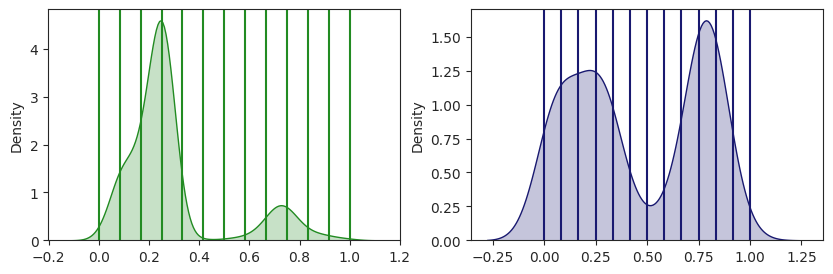

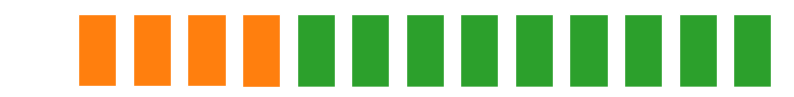

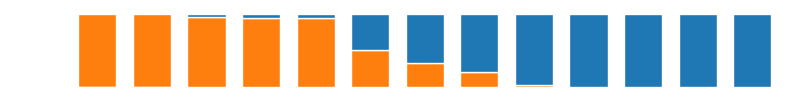

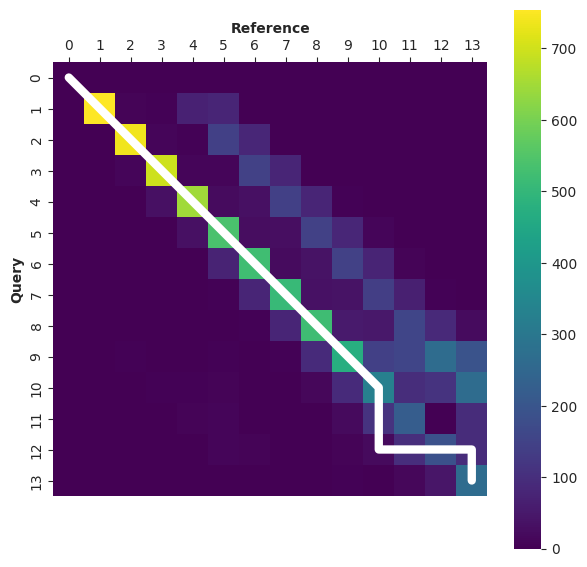

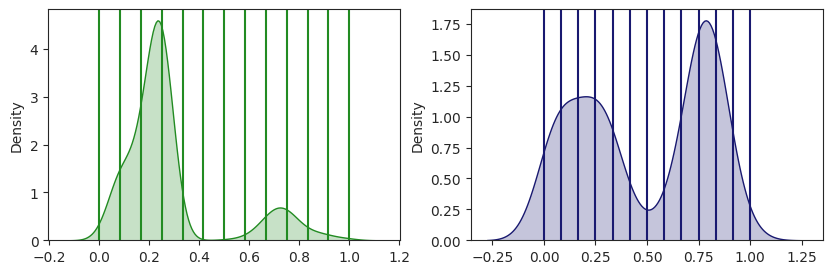

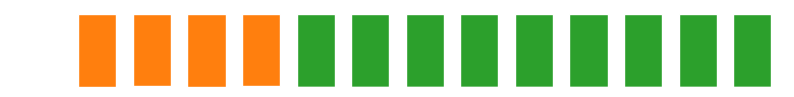

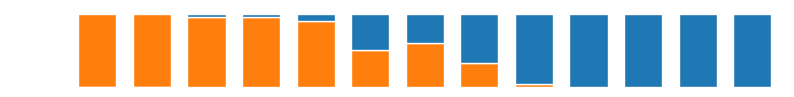

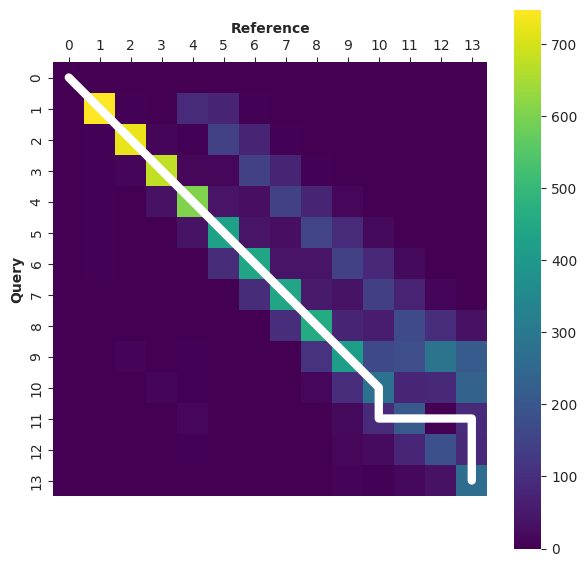

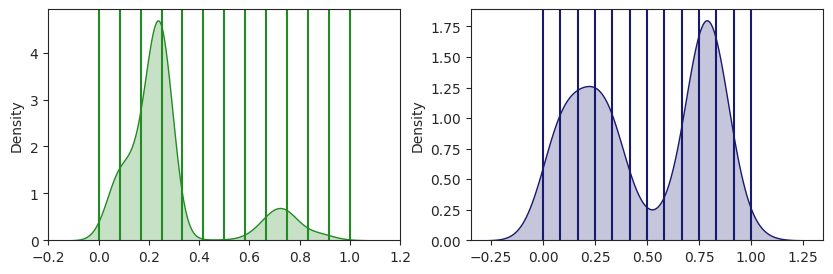

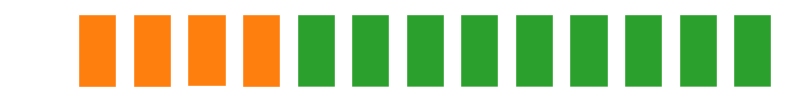

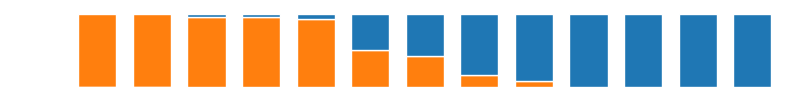

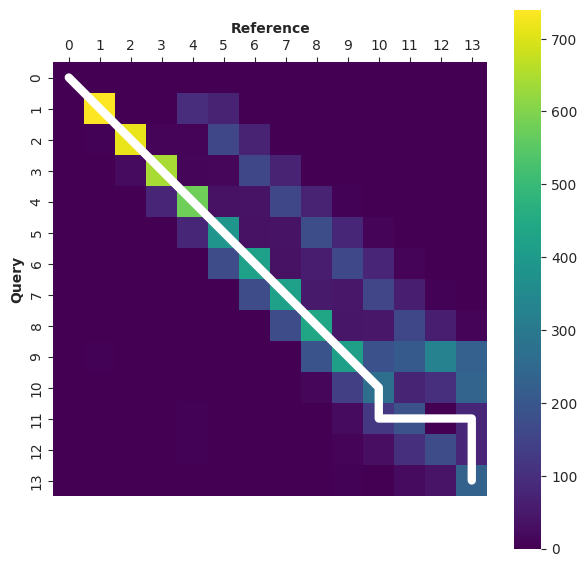

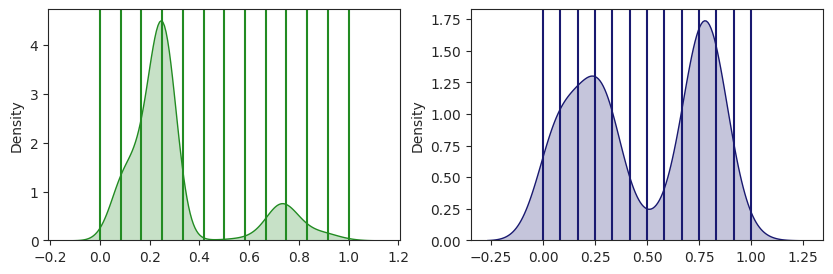

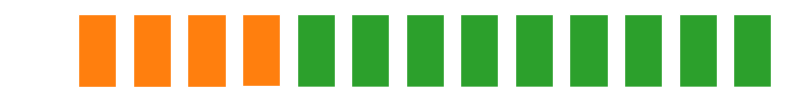

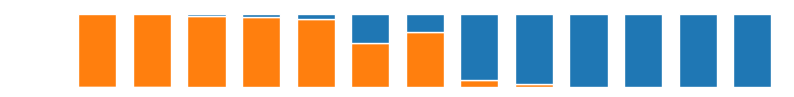

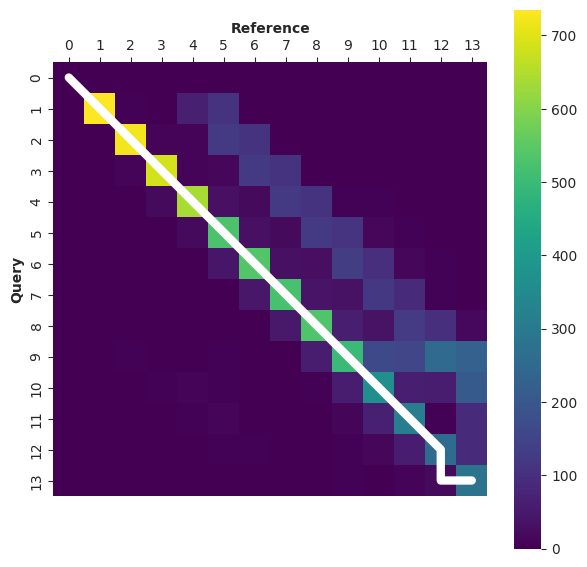

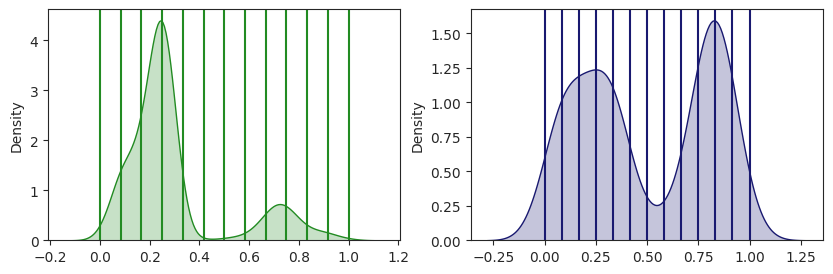

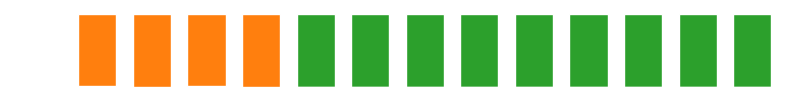

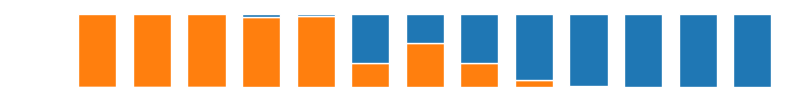

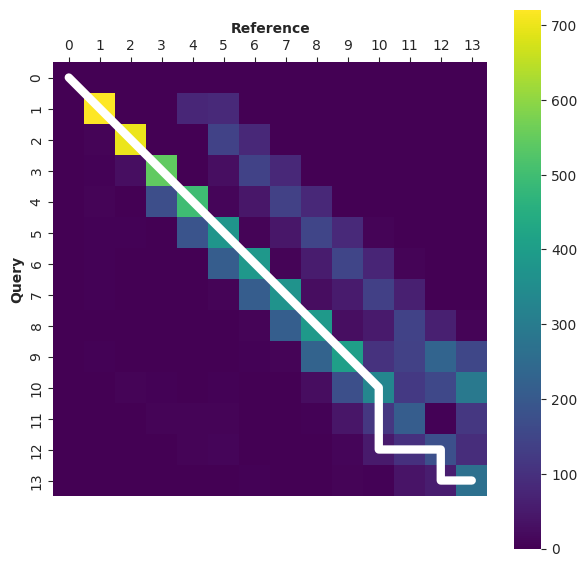

In [32]:
np.random.seed(1234)
for i in range(0,5):
    print(i)
    adata_healthy = adata_healthy_original.copy()
    adata_disease = adata_disease_original.copy()
    
    adata_healthy = adata_healthy[np.random.choice(adata_healthy.obs_names, int(adata_healthy.shape[0]  * 50/100) , replace=False)]
    adata_disease = adata_disease[np.random.choice(adata_disease.obs_names, int(adata_disease.shape[0]  * 50/100) , replace=False)]
    
  #  sc.pl.embedding(adata_healthy, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
  #  sc.pl.embedding(adata_disease, basis='umap', color= ['Manuscript_Identity', 'dpt_pseudotime', 'dpt_start_score' ], legend_loc='on data')
   # print('-----')

    adata_healthy.obs['time'] = adata_healthy.obs['dpt_pseudotime']
    adata_disease.obs['time'] = adata_disease.obs['dpt_pseudotime']

    print( np.min(adata_healthy.obs.time) , np.max(adata_healthy.obs.time) ) 
    print( np.min(adata_disease.obs.time) , np.max(adata_disease.obs.time) ) 
    
    adata_healthy.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_healthy.obs['time']))
    adata_disease.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_disease.obs['time']))
    
    print( np.min(adata_healthy.obs.time) , np.max(adata_healthy.obs.time) ) 
    print( np.min(adata_disease.obs.time) , np.max(adata_disease.obs.time) ) 
    
    
    # Examine ref and query pseudotime distributions
   # sb.kdeplot(adata_healthy.obs['dpt_pseudotime'], fill=True, label='Healthy', color='forestgreen') 
  #  sb.kdeplot(adata_disease.obs['dpt_pseudotime'], fill=True, label='IPF', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
   # plt.show()
    
    joint_cmap = {'ATII': '#ff7f0e', 'ATI': '#2ca02c','Aberrant_Basaloid': '#1f77b4'}
    vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_healthy, adata_disease, n_points=13, 
                                         ANNOTATION_COLNAME='Manuscript_Identity', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

    
    adata_ref = adata_healthy
    adata_query = adata_disease
    print(adata_ref.X.data) 
    print(adata_query.X.data)
    sc.pp.normalize_per_cell(adata_ref, 10000) 
    sc.pp.log1p(adata_ref)
    sc.pp.normalize_per_cell(adata_query, 10000) 
    sc.pp.log1p(adata_query)
    print(adata_ref.X.data)
    print(adata_query.X.data)

    # RUN G2G ALIGNMENT
    RUN_G2G = True
    if(RUN_G2G):
        aligner = Main.RefQueryAligner(adata_ref, adata_query, common_hvg_genes, len(vs.optimal_bining_S))
        aligner.WEIGHT_BY_CELL_DENSITY = True
        aligner.WINDOW_SIZE=0.1
        aligner.state_params = [0.99,0.1,0.7]
        aligner.optimal_binning = True
        aligner.opt_binning_S = vs.optimal_bining_S
        aligner.opt_binning_T = vs.optimal_bining_T
        aligner.align_all_pairs()
    
        aligner.get_aggregate_alignment()